## Latar Belakang

Maintenance pada suatu mesin umumnya dilakukan pada saat kegagalan (failure) telah terjadi. Hal ini dapat menyebabkan kerugian materil diakibatkan karena proses produksi secara mendadak. Solusi dari hal ini adalah dengan melakukan monitoring kondisi kesehatan mesin secara berkala maupun real-time.

Kondisi kesehatan mesin umumnya dapat dinilai dengan beberapa variable seperi suhu, getaran, dan tingkat kebisingan. Getaran menjadi salah satu faktor yang cukup dominan untuk menilai kesehatan mesin. Umumnya mesin yang akan mengalami kegagalan, memiliki karakteristik dan pola getaran yang unik menyesuaikan penyebab kegagalannya. Penyebab dari kegagalan mesin pun beragam, mulai dari disebabkan karena imbalance, misalignment, friksi, dsb.

Tidak semua divisi maintenance pada perusahaan memiliki orang-orang yang ahli dalam menganalisa “mechanical vibration”. Pola getaran yang dihasilkan oleh mesin terkesan acak, sehingga sulit membedakan keunikan pola pada masing-masing jenis kegagalan. Dengan memanfaatkan machine learning, diharapkan mampu dengan mudah mengenal pola getaran dan melakukan klasifikasi penyebab kegagalan pada mesin sehingga dapat menentukan treatment yang tepat.

Projek ini akan membahas tentang metode klasifikasi kegagalan yang ditimbulkan oleh mesin berdasarkan pola getarannya. Sebagai pengganti mesin, project ini akan menggunakan Fan untuk memahami jenis kegagalannya. Adapun jenis kegagalan akan dibagi berdasarkan 5 kelas:

    1.	Fan beroperasi normal
    2.	Aliran pada fan terblokir
    3.	Imbalance tingkat 1
    4.	Imbalance tingkat 2
    5.	Imbalance tingkat 3


## Akusisi Data
Akusisi data menggunakan sensor getaran MPU6050 dan microcontroller Arduino. Data yang diambil adalah akselerasi getaran dalam arah sumbu X,Y, dan Z dimana sensor diletakkan secara horizontal diatas fan.

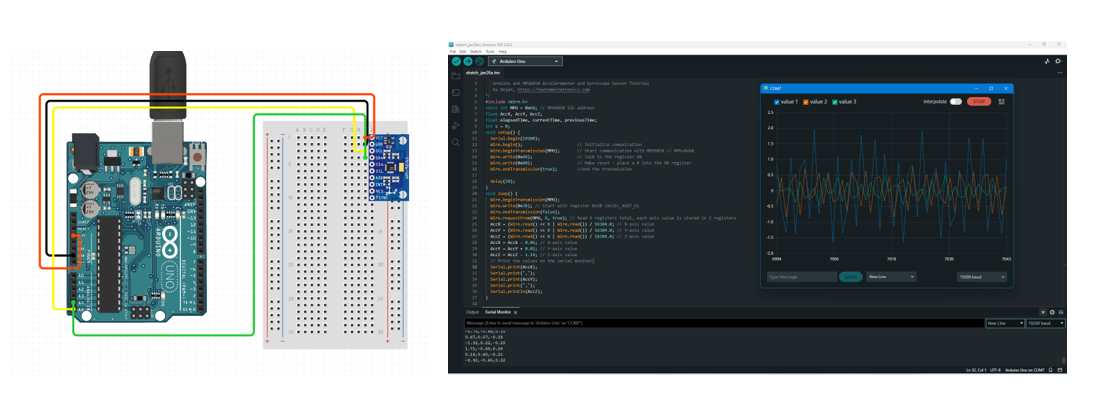

Data getaran kemudian distream ke Microsoft excel dan direcord selama 10 menit pada 5 kondisi sesuai dengan masing-masing kelas. Setelah itu data getaran disave dalam format csv yang selanjutnya akan digunakan untuk mentraining model ML.


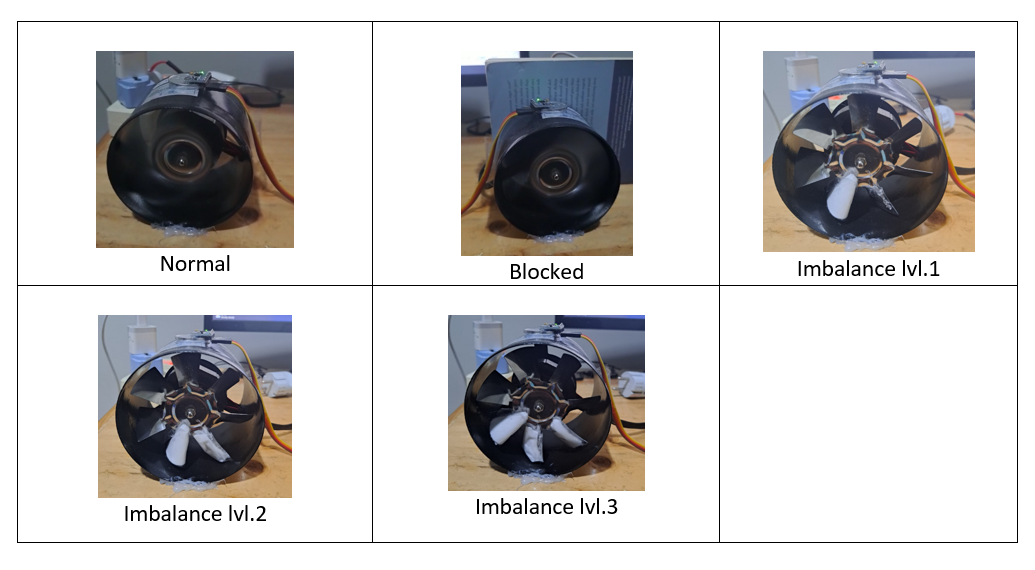

## Membersihkan Data
Raw data yang dihasilkan berupa 5 buah file berformat csv yang terdiri dari data akselerasi X,Y, dan Z. Data-data ini perlu dicleanup karena formatnya tidak sesuai standar.

In [39]:
import pandas as pd
import numpy as np

normal_raw = pd.read_csv("sensor_data/normal_acc1.csv", header=None)
blocked_raw = pd.read_csv("sensor_data/blocked_acc1.csv", header=None)
imb1_raw = pd.read_csv("sensor_data/imb1_acc1.csv", header=None)
imb2_raw = pd.read_csv("sensor_data/imb3_acc1.csv", header=None)

In [40]:
normal_raw.head(4)

,0,1,2,3
0,#!,Workbook:,Custom,Custom
1,#!,To play this data back: Open the original Exce...,NaN,NaN
2,#!,For more information visit http://aka.ms/hacki...,NaN,NaN
3,-0.46,-0.18,0.07,NaN


In [41]:
def cleanup(data):
    data = data.drop([3], axis=1)
    data = data.dropna()
    data = data.drop([0])
    data = data.reset_index()
    data = data.drop(["index"], axis=1)
    data = data.astype(float)
    #data = data.iloc[5:((dim*n)+5)]
    data = data.reset_index()
    data = data.drop(["index"], axis=1)
    #data = np.array(data)
    #data = pd.DataFrame(data.reshape(dim,n, order="F")) 
    return data

normal_clean = cleanup(normal_raw)
blocked_clean = cleanup(blocked_raw)
imb1_clean = cleanup(imb1_raw)
imb2_clean = cleanup(imb2_raw)

In [42]:
normal_clean

,0,1,2
0,-0.46,-0.18,0.07
1,-0.69,-0.17,0.01
2,-0.25,-0.20,-0.04
3,-0.48,-0.04,-0.08
4,-0.32,-0.06,-0.10
...,...,...,...
37470,-0.47,0.01,-0.06
37471,-0.32,-0.11,-0.02
37472,-0.23,-0.11,-0.11
37473,0.01,0.28,-0.05


dari tabel diatas didapatkan data yang sudah dibersihkan dimana kolom-0 mewakili akselerasi-x, kolom-1 mewakili akselerasi-y, dan kolom-2 mewakili akselerasi-z. Untuk mengetahui feature mana yang paling mewakili keunikan setiap kelas, dibutuhkan eksplorasi data lebih detail untuk setiap feature.

## Eksplorasi Data Akselerasi

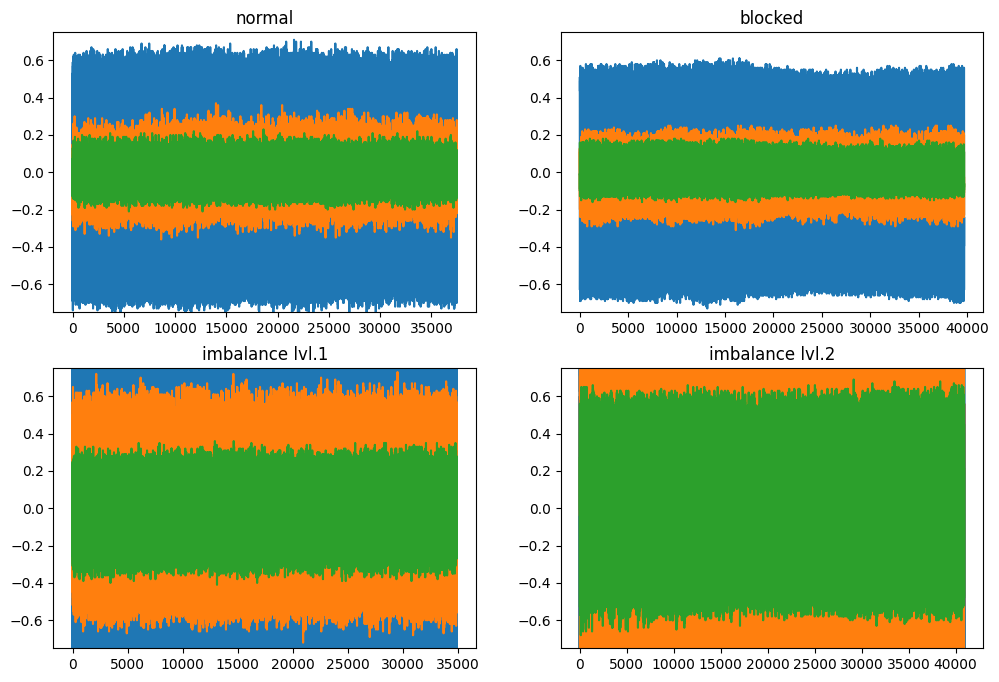

In [43]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12,8))
plt.subplot(221)
plt.plot(normal_clean)
plt.title("normal")
plt.ylim(-0.75, 0.75)

plt.subplot(222)
plt.plot(blocked_clean)
plt.title("blocked")
plt.ylim(-0.75, 0.75)

plt.subplot(223)
plt.plot(imb1_clean)
plt.title("imbalance lvl.1")
plt.ylim(-0.75, 0.75)

plt.subplot(224)
plt.plot(imb2_clean)
plt.title("imbalance lvl.2")
plt.ylim(-0.75, 0.75)

plt.show()

Untuk akselerasi XYZ pada plot diatas, didapatkan bahwa pola getarannya "unik" untuk setiap kelasnya, terkecuali kelas normal Vs blocked yang sulit dikenali perbedaannya. Oleh karena itu perlu meninjau lebih detail pattern antara kelas normal vs blocked.

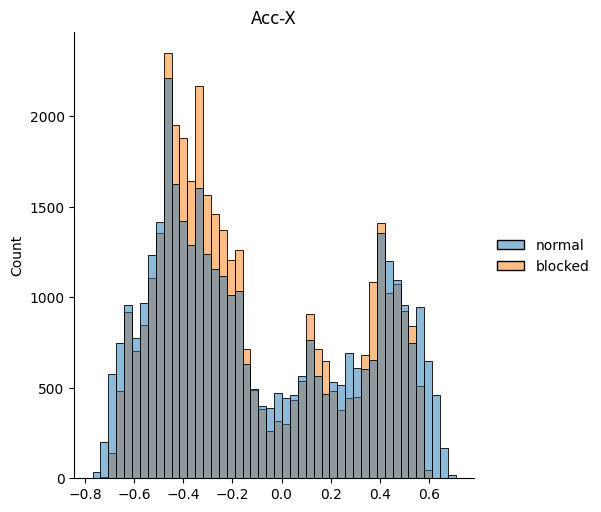

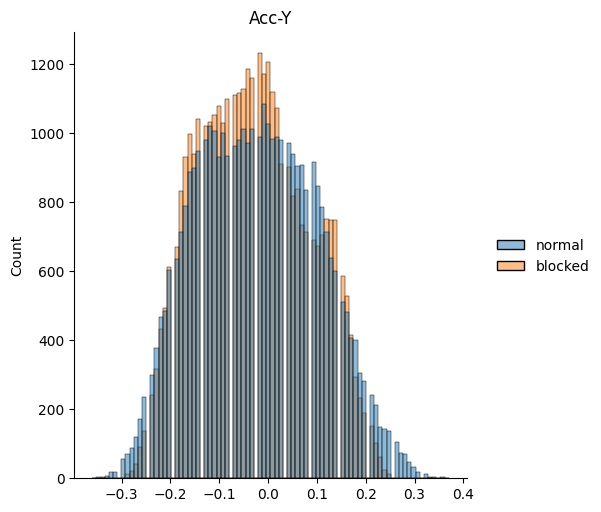

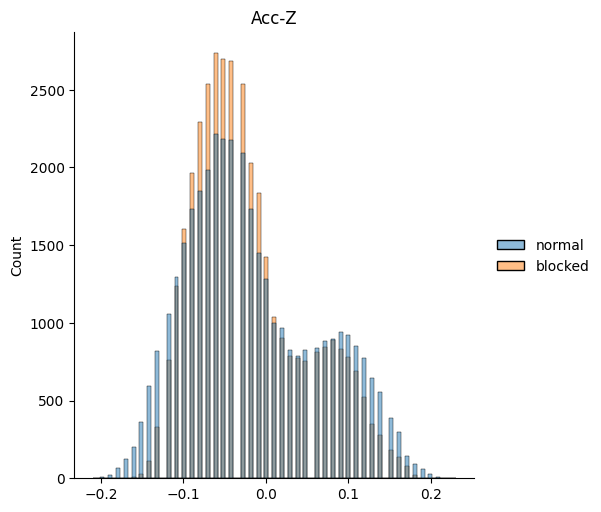

In [44]:
import seaborn as sns

X_data = pd.DataFrame([])
X_data["normal"] = normal_clean[0]
X_data["blocked"] = blocked_clean[0]


Y_data = pd.DataFrame([])
Y_data["normal"] = normal_clean[1]
Y_data["blocked"] = blocked_clean[1]


Z_data = pd.DataFrame([])
Z_data["normal"] = normal_clean[2]
Z_data["blocked"] = blocked_clean[2]

sns.displot(X_data)
plt.title("Acc-X")
sns.displot(Y_data)
plt.title("Acc-Y")
sns.displot(Z_data)
plt.title("Acc-Z")
plt.show()

Berdasarkan plot diatas didapatkan bahwa akselerasi-Z memiliki features yang cukup unik untuk membedakan antara kelas normal dan blocked. Oleh karena itu, feature yang dipilih untuk mentraining model adalah akselerasi-Z.

Selanjutnya kita akan membagi dataset menjadi 400 buah untuk masing-masing kelas dengan resolusi 64 point data sensor sehingga tabel yang dihasilkan sebanyak 64x400 untuk setiap kelasnya.

In [45]:
def separate_data(data, res, n, feature):
    data = data[feature]
    data = data.iloc[3:((res*n)+3)]
    data = np.array(data)
    data = pd.DataFrame(data.reshape(res,n, order="F"))
    return data

normal_sep = separate_data(normal_clean, res=64, n=400, feature=2)
blocked_sep = separate_data(blocked_clean, res=64, n=400, feature=2)
imb1_sep = separate_data(imb1_clean, res=64, n=400, feature=2)
imb2_sep = separate_data(imb2_clean, res=64, n=400, feature=2)

normal_sep

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,-0.08,-0.04,0.04,0.15,-0.04,-0.11,0.08,0.04,-0.03,-0.02,...,0.10,-0.12,0.09,-0.07,-0.06,0.06,-0.11,0.01,-0.05,-0.15
1,-0.10,-0.06,-0.07,0.12,-0.02,-0.10,-0.02,-0.11,-0.03,-0.19,...,0.07,-0.01,-0.01,-0.01,-0.05,0.07,-0.04,-0.06,0.00,-0.06
2,-0.02,-0.14,-0.06,0.06,-0.09,-0.09,-0.01,-0.03,-0.06,-0.02,...,0.01,-0.06,-0.09,0.05,-0.09,-0.06,-0.08,0.06,-0.06,-0.01
3,-0.12,-0.09,-0.10,0.08,0.00,-0.04,-0.10,-0.07,0.04,-0.04,...,-0.07,-0.05,-0.10,0.10,0.08,-0.05,-0.02,0.09,-0.14,-0.08
4,-0.13,0.02,-0.04,-0.06,0.05,-0.07,-0.04,-0.09,0.16,-0.11,...,-0.08,-0.03,-0.04,0.17,0.02,-0.08,-0.08,0.05,-0.04,-0.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,-0.06,0.07,-0.08,-0.07,0.01,-0.01,0.01,-0.05,0.13,-0.00,...,-0.03,-0.05,0.01,0.01,-0.04,0.06,-0.11,0.07,0.06,-0.06
60,-0.06,0.04,-0.06,-0.07,0.16,0.02,0.12,-0.11,0.06,0.04,...,-0.02,-0.06,0.02,-0.06,-0.08,0.13,-0.03,0.17,-0.12,-0.12
61,-0.06,0.13,0.00,-0.13,0.05,-0.13,0.06,-0.11,0.12,0.11,...,-0.08,0.06,-0.03,-0.10,0.03,-0.15,-0.10,0.09,-0.02,0.06
62,-0.07,-0.02,-0.11,-0.08,0.07,0.11,-0.01,-0.03,-0.08,0.07,...,-0.13,0.06,-0.13,-0.08,0.16,-0.01,-0.13,-0.06,-0.06,0.07


## Eksplorasi data time domain

Data yang dihasilkan oleh sensor getaran pada dasarnya merupakan domain waktu dimana sensor mengambil data akselerasi di setiap point waktu perekaman. Nilai getaran berosilasi secara acak sehingga sulit dicarikan patternnya jika ditinjau dalam domain waktu. Oleh karena itu, umumnya karakteristik getaran dianalisis dalam domain frequency. Dibawah ini merupakan contoh 1 sample data yang diambil pada masing-masing kelas dalam time domain.

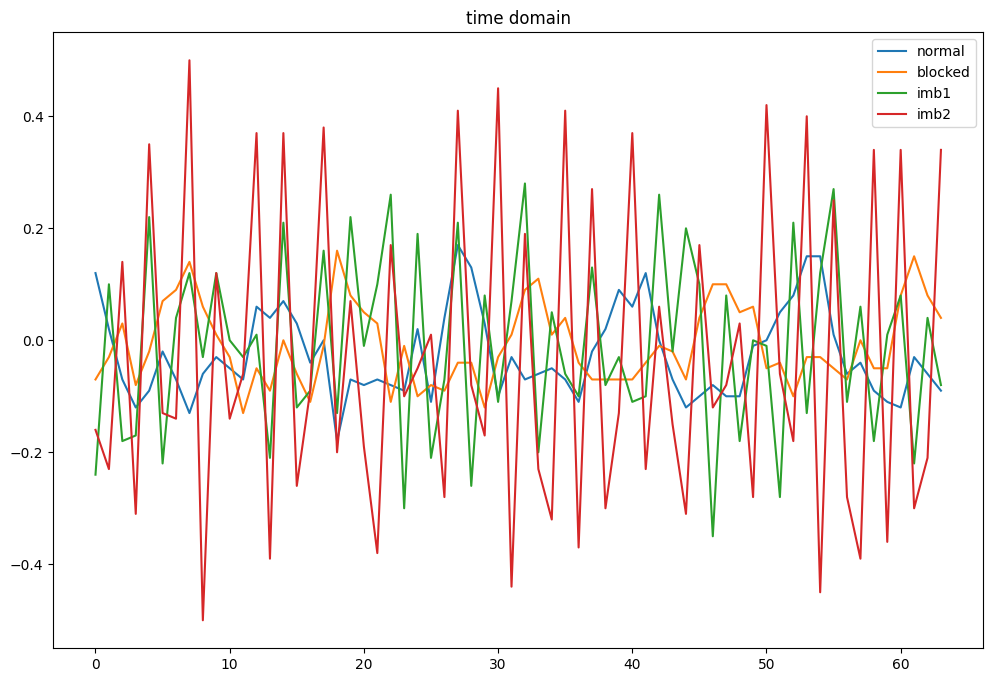

In [46]:
#cek data u
plt.figure(figsize=(12, 8))

plt.plot(normal_sep[55], label="normal")
plt.plot(blocked_sep[55], label="blocked")
plt.plot(imb1_sep[55], label="imb1")
plt.plot(imb2_sep[55], label="imb2")
plt.title("time domain")
plt.legend()
plt.show()

Walaupun patternnya sulit dibedakan,diprojek kali ini, kita akan coba tetap menggunakan feature-feature baik dari time domain maupun frequency domain. Ada beberapa feature yang dapat kita ekstrak dari data time-domain:

    1. Mean
    2. Variance
    3. Skewness
    4. Kurtosis

#### 1-Mean

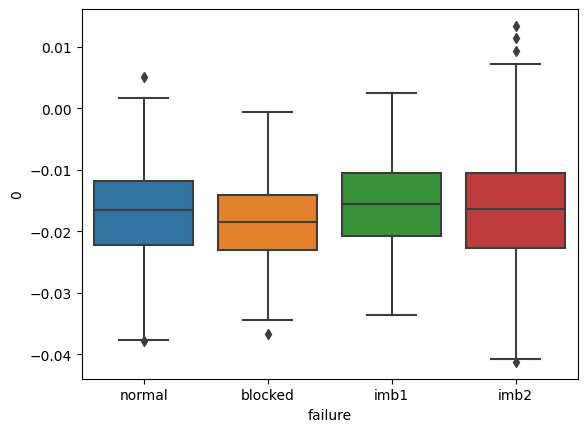

In [47]:
#Calculate mean
normal_mean = normal_sep.mean(axis=0)
blocked_mean = blocked_sep.mean(axis=0)
imb1_mean = imb1_sep.mean(axis=0)
imb2_mean = imb2_sep.mean(axis=0)

#Labelin data
def labelin(data, label):
    data = pd.DataFrame(data)
    data["failure"] = label
    return data

normal_mean = labelin(normal_mean, label="normal")
blocked_mean = labelin(blocked_mean, label="blocked")
imb1_mean = labelin(imb1_mean, label="imb1")
imb2_mean = labelin(imb2_mean, label="imb2")

means = pd.concat([normal_mean, blocked_mean, imb1_mean, imb2_mean],axis=0)

means
sns.boxplot(x=means["failure"], y=means[0])
plt.show()

dari boxplot diatas didapatkan bahwa variabel mean tidak cocok dijadikan sebagai feature karena pola pada masing-masing kelas tidak unik, setiap kelas hampir memiliki nilai mean yang sama.

#### 2-Variance

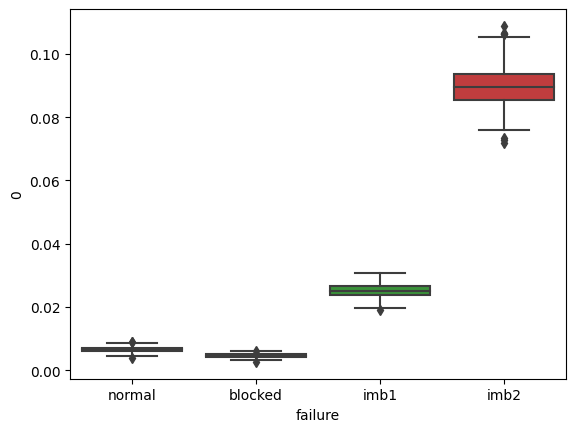

In [48]:
#Calculate var
normal_var = normal_sep.var(axis=0)
blocked_var = blocked_sep.var(axis=0)
imb1_var = imb1_sep.var(axis=0)
imb2_var = imb2_sep.var(axis=0)

#Labelin data
def labelin(data, label):
    data = pd.DataFrame(data)
    data["failure"] = label
    return data

normal_var = labelin(normal_var, label="normal")
blocked_var = labelin(blocked_var, label="blocked")
imb1_var = labelin(imb1_var, label="imb1")
imb2_var = labelin(imb2_var, label="imb2")

vars = pd.concat([normal_var, blocked_var, imb1_var, imb2_var],axis=0)

vars
sns.boxplot(x=vars["failure"], y=vars[0])
plt.show()

dari boxplot diatas didapatkan bahwa variabel variance dapat dipertimbangkan dijadikan sebagai features karena memiliki pola yang unik pada setiap kelasnya, walaupun pattern pada kelas normal dan blocked masih relatif sama.

#### 3-Skewness

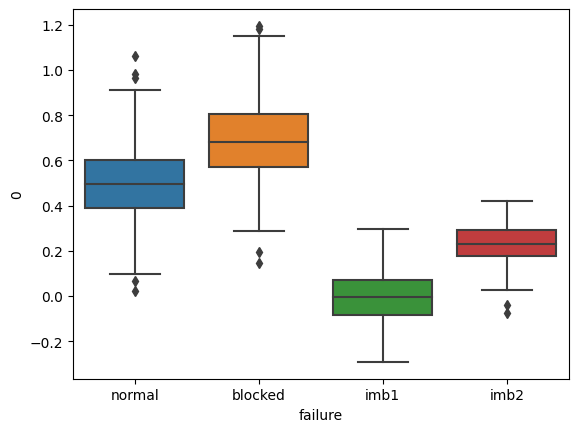

In [49]:
#Calculate skew
normal_skew = normal_sep.skew(axis=0)
blocked_skew = blocked_sep.skew(axis=0)
imb1_skew = imb1_sep.skew(axis=0)
imb2_skew = imb2_sep.skew(axis=0)

#Labelin data
def labelin(data, label):
    data = pd.DataFrame(data)
    data["failure"] = label
    return data

normal_skew = labelin(normal_skew, label="normal")
blocked_skew = labelin(blocked_skew, label="blocked")
imb1_skew = labelin(imb1_skew, label="imb1")
imb2_skew = labelin(imb2_skew, label="imb2")

skews = pd.concat([normal_skew, blocked_skew, imb1_skew, imb2_skew],axis=0)

skews
sns.boxplot(x=skews["failure"], y=skews[0])
plt.show()

dari boxplot diatas didapatkan bahwa variabel skewness cukup dapat dipertimbangkan dijadikan sebagai features walaupun tidak sekuat variance.

#### 4-Kurtosis

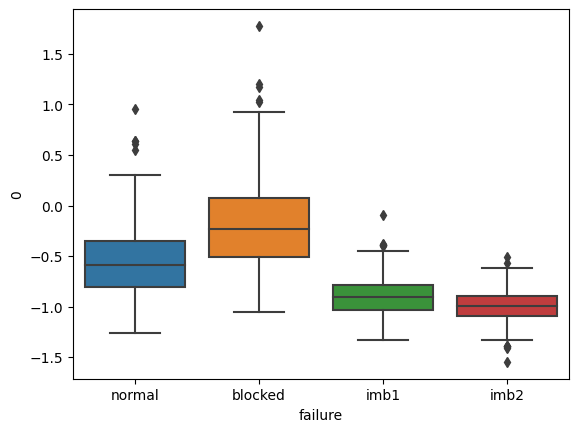

In [50]:
#Calculate kurtosis
normal_kurtosis = normal_sep.kurtosis(axis=0)
blocked_kurtosis = blocked_sep.kurtosis(axis=0)
imb1_kurtosis = imb1_sep.kurtosis(axis=0)
imb2_kurtosis = imb2_sep.kurtosis(axis=0)

#Labelin data
def labelin(data, label):
    data = pd.DataFrame(data)
    data["failure"] = label
    return data

normal_kurtosis = labelin(normal_kurtosis, label="normal")
blocked_kurtosis = labelin(blocked_kurtosis, label="blocked")
imb1_kurtosis = labelin(imb1_kurtosis, label="imb1")
imb2_kurtosis = labelin(imb2_kurtosis, label="imb2")

kurtosiss = pd.concat([normal_kurtosis, blocked_kurtosis, imb1_kurtosis, imb2_kurtosis],axis=0)

kurtosiss
sns.boxplot(x=kurtosiss["failure"], y=kurtosiss[0])
plt.show()

dari boxplot diatas didapatkan bahwa variabel kurtosis cukup dapat dipertimbangkan dijadikan sebagai features walaupun tidak sekuat variance.

Dari keempat features diatas didapatkan bahwa variance lebih baik dalam hal menjelaskan keunikan setiap kelas. Diikuti oleh skewness dan kurtosis. Mean dalam hal ini memiliki performa yang sangat buruk. Sekarang kita akan lihat lebih detail lagi dalam plot 2 dimensi, jika kita menggabungkan feature-feature tersebut sebagai berikut:

    1. Variance-Skewness
    2. Variance-Kurtosis
    3. Skewness-Kurtosis
    4. Variance-Mean

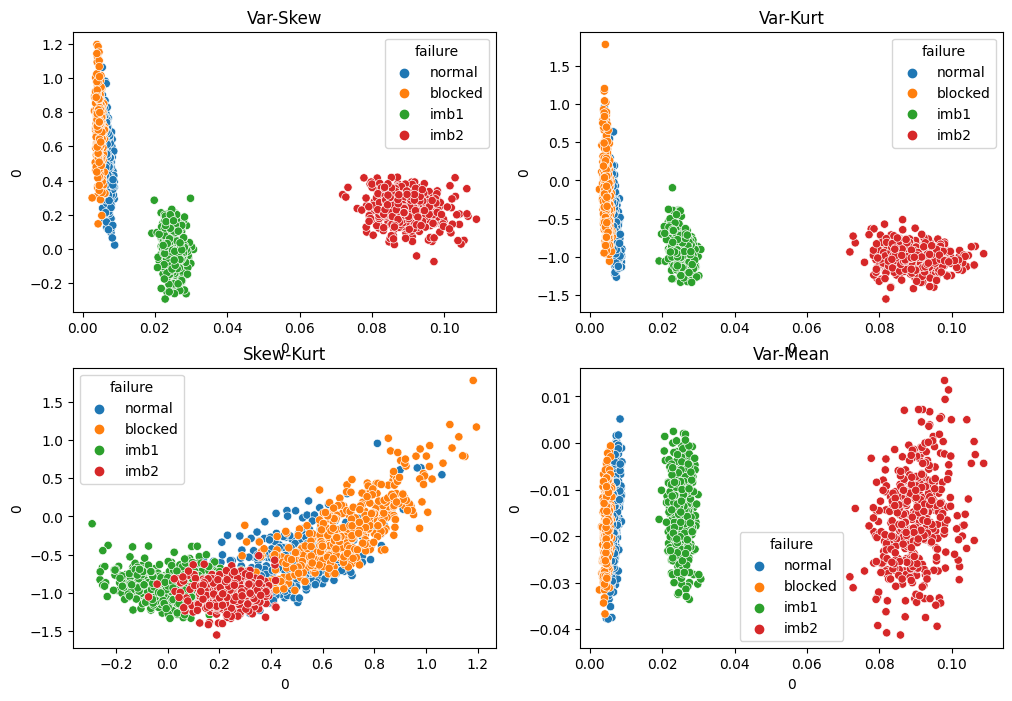

In [51]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))
sns.scatterplot(x=vars[0], y=skews[0], hue=vars["failure"], ax=axes[0,0])
axes[0,0].set_title("Var-Skew")
sns.scatterplot(x=vars[0], y=kurtosiss[0], hue=vars["failure"], ax=axes[0,1])
axes[0,1].set_title("Var-Kurt")
sns.scatterplot(x=skews[0], y=kurtosiss[0], hue=vars["failure"], ax=axes[1,0])
axes[1,0].set_title("Skew-Kurt")
sns.scatterplot(x=vars[0], y=means[0], hue=vars["failure"], ax=axes[1,1])
axes[1,1].set_title("Var-Mean")
plt.show()

Dari plot diatas didapatkan bahwa hanya feature skewness-kurtosis yang memiliki performa paling buruk. Kita akan coba pilih feature Variance-Mean untuk keperluan training model machine learning karena boundary-nya paling mudah dikenali.

In [52]:
var_mean_data = pd.DataFrame([])
var_mean_data["mean"] = means[0]
var_mean_data["var"] = vars[0]
var_mean_data["failure"] = vars["failure"]
var_mean_data

,mean,var,failure
0,-0.037656,0.004558,normal
1,-0.018594,0.006730,normal
2,-0.009531,0.006452,normal
3,-0.012500,0.007486,normal
4,-0.020000,0.006676,normal
...,...,...,...
395,-0.029531,0.088843,imb2
396,-0.017500,0.086203,imb2
397,-0.024375,0.089676,imb2
398,-0.025625,0.083485,imb2


## Membuat model ML dengan feature time domain

In [53]:
#Split data train-test

from sklearn.model_selection import train_test_split

def split_input_output(data, target_column):
    X = data.drop(columns = target_column)
    y = data[target_column]
    
    return X, y

X,y = split_input_output(data=var_mean_data, target_column="failure")

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 123)
y_train.value_counts()

normal     328
imb2       320
blocked    319
imb1       313
Name: failure, dtype: int64

In [54]:
#Standarisasi data

from sklearn.preprocessing import StandardScaler

# Buat scaler
scaler = StandardScaler()
scaler = scaler.fit(X_train)

def scaler_transform(data, scaler):
    data_scaled = scaler.transform(data)
    data_scaled = pd.DataFrame(data_scaled)
    data_scaled.columns = data.columns
    data_scaled.index = data.index

    return data_scaled

X_train_scaled = scaler_transform(data = X_train,
                                  scaler = scaler)
X_test_scaled = scaler_transform(data = X_test,
                                 scaler = scaler)

X_test_scaled.head()

,mean,var
112,-0.623692,-0.281268
372,-0.502990,-0.776187
237,0.764386,-0.114503
306,-0.704160,-0.194627
263,-0.663926,-0.719141


#### 1-LogisticRegression

In [55]:
#Train menggunakan multiclass classification - Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg = logreg.fit(X_train_scaled, y_train)

In [56]:
#buat prediksi pada data train dan test
y_pred_train = logreg.predict(X_train_scaled)
y_pred_test = logreg.predict(X_test_scaled)

In [57]:
#Evaluasi hasil prediksi metrics pada data train

from sklearn import metrics

print(metrics.classification_report(y_true = y_train,
                            y_pred = y_pred_train,
                            target_names = ["normal", "blocked","imb1", "imb2"]))

              precision    recall  f1-score   support

      normal       0.71      0.81      0.76       319
     blocked       1.00      1.00      1.00       313
        imb1       1.00      1.00      1.00       320
        imb2       0.79      0.67      0.72       328

    accuracy                           0.87      1280
   macro avg       0.87      0.87      0.87      1280
weighted avg       0.87      0.87      0.87      1280



In [58]:
#Evaluasi hasil prediksi metrics pada data test
print(metrics.classification_report(y_true = y_test,
                            y_pred = y_pred_test,
                            target_names = ["normal", "blocked","imb1", "imb2"]))

              precision    recall  f1-score   support

      normal       0.71      0.81      0.76        81
     blocked       1.00      1.00      1.00        87
        imb1       1.00      1.00      1.00        80
        imb2       0.75      0.62      0.68        72

    accuracy                           0.87       320
   macro avg       0.86      0.86      0.86       320
weighted avg       0.87      0.87      0.87       320



#### 2-KNN

In [59]:
#Training menggunakan KNN
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn = knn.fit(X_train_scaled, y_train)

In [60]:
#buat prediksi pada data train dan test
y_pred_train = knn.predict(X_train_scaled)
y_pred_test = knn.predict(X_test_scaled)

In [61]:
#Evaluasi hasil prediksi metrics pada data train

print(metrics.classification_report(y_true = y_train,
                            y_pred = y_pred_train,
                            target_names = ["normal", "blocked","imb1", "imb2"]))

              precision    recall  f1-score   support

      normal       0.90      0.94      0.92       319
     blocked       1.00      1.00      1.00       313
        imb1       1.00      1.00      1.00       320
        imb2       0.94      0.90      0.92       328

    accuracy                           0.96      1280
   macro avg       0.96      0.96      0.96      1280
weighted avg       0.96      0.96      0.96      1280



In [62]:
#Evaluasi hasil prediksi metrics pada data test
print(metrics.classification_report(y_true = y_test,
                            y_pred = y_pred_test,
                            target_names = ["normal", "blocked","imb1", "imb2"]))

              precision    recall  f1-score   support

      normal       0.84      0.90      0.87        81
     blocked       1.00      1.00      1.00        87
        imb1       1.00      1.00      1.00        80
        imb2       0.88      0.81      0.84        72

    accuracy                           0.93       320
   macro avg       0.93      0.93      0.93       320
weighted avg       0.93      0.93      0.93       320



#### 3-Random Forest

In [63]:
#Training menggunakan Random Forest
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(random_state = 123)
random_forest = random_forest.fit(X_train_scaled, y_train)

In [64]:
#buat prediksi pada data train dan test
y_pred_train = knn.predict(X_train_scaled)
y_pred_test = knn.predict(X_test_scaled)

In [65]:
#Evaluasi hasil prediksi metrics pada data train

print(metrics.classification_report(y_true = y_train,
                            y_pred = y_pred_train,
                            target_names = ["normal", "blocked","imb1", "imb2"]))

              precision    recall  f1-score   support

      normal       0.90      0.94      0.92       319
     blocked       1.00      1.00      1.00       313
        imb1       1.00      1.00      1.00       320
        imb2       0.94      0.90      0.92       328

    accuracy                           0.96      1280
   macro avg       0.96      0.96      0.96      1280
weighted avg       0.96      0.96      0.96      1280



In [66]:
#Evaluasi hasil prediksi metrics pada data test
print(metrics.classification_report(y_true = y_test,
                            y_pred = y_pred_test,
                            target_names = ["normal", "blocked","imb1", "imb2"]))

              precision    recall  f1-score   support

      normal       0.84      0.90      0.87        81
     blocked       1.00      1.00      1.00        87
        imb1       1.00      1.00      1.00        80
        imb2       0.88      0.81      0.84        72

    accuracy                           0.93       320
   macro avg       0.93      0.93      0.93       320
weighted avg       0.93      0.93      0.93       320



## Eksplorasi data pada frequency domain

Setelah melakukan pemodelan pada feature-feature time domain, kali ini akan kita coba eksplorasi feature-feature pada frequency domain. Frequency domain umum digunakan karena patternnya lebih mudah dikenali secara visual dibandingkan time domain. Untuk mendapatkan data pada frequency domain, diperlukan fourier transform:

In [67]:
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

#Ubah data ke frequency domain dengan fourier transform

def ubah_fourier(data_sep):
    data = pd.DataFrame([])
    for column in data_sep:
        n = len(data_sep[column])
        data[column] = np.fft.fft(np.array(data_sep[column]), n)
    return data

normal_fourier = ubah_fourier(normal_sep)
blocked_fourier = ubah_fourier(blocked_sep)
imb1_fourier = ubah_fourier(imb1_sep)
imb2_fourier = ubah_fourier(imb2_sep)

normal_fourier.head()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,-2.410000+0.000000j,-1.190000+0.000000j,-0.610000+0.000000j,-0.800000+0.000000j,-1.280000+0.000000j,-1.530000+0.000000j,-1.320000+0.000000j,-2.150000+0.000000j,-0.950000+0.000000j,-1.040000+0.000000j,...,-1.480000+0.000000j,-0.740000+0.000000j,-0.540000+0.000000j,-1.520000+0.000000j,-1.410000+0.000000j,-1.120000+0.000000j,-1.320000+0.000000j,-0.700000+0.000000j,-0.290000+0.000000j,-0.780000+0.000000j
1,-0.243835-0.003306j,0.036168-0.127547j,-0.540369+0.603700j,0.007511-0.201013j,-0.249792+0.182773j,-0.074307+0.361841j,0.264097-0.144489j,-0.292140-0.033860j,0.155193+0.000554j,-0.007445-0.275672j,...,0.101217-0.364373j,0.213360-0.306472j,-0.581799-0.319719j,-0.056484-0.392393j,-0.043465+0.247326j,0.126213+0.186751j,-0.589394-0.654943j,0.253952+0.388629j,-0.295241+0.196461j,0.000242+0.087778j
2,-0.697450+0.105774j,-0.289926-0.177395j,-0.603295-0.427136j,0.220657-0.504852j,0.964210+0.035559j,0.114691-0.151123j,0.098666+0.043531j,-0.206631+0.042666j,0.507758+0.133390j,-0.168431+0.399693j,...,-0.028116+0.108775j,0.110359-0.194686j,0.052647+0.193412j,0.239189-0.304815j,0.413323-0.086672j,0.017084-0.217226j,-0.679302+0.277563j,0.059496+0.621467j,-0.708629-0.307997j,-0.816413-0.191037j
3,-0.582425+0.616735j,0.512793+0.154690j,-0.531538+0.111110j,-0.362240+0.161888j,0.862170+0.173851j,-0.268027-0.114612j,0.359396+0.113776j,-0.632254+0.032051j,0.417769-0.062885j,-0.343207-0.076051j,...,-0.518676-0.110301j,-0.132092-0.241155j,-0.566821+0.521999j,0.512133-0.586137j,0.665616-0.014969j,-0.149874+0.657549j,-1.121785+0.286525j,0.687101+0.001790j,-0.460454+0.223646j,-0.106159-0.776003j
4,-1.526599+0.249290j,-0.708812-0.655049j,-0.519781+0.689528j,-0.042890+0.392992j,0.801025-0.714569j,-0.773520-1.035545j,0.738503+1.993169j,-1.286789-0.547778j,0.861169+1.363536j,0.411792-0.069469j,...,-1.284457+1.017540j,0.184025-1.257133j,-0.583089+1.966907j,0.268042+0.985181j,0.757603-1.302082j,0.957773+1.827748j,-0.925473-0.619992j,1.376314-0.253987j,-0.199337-0.312310j,-1.328285+0.631302j


Karena data diatas masih berupa bilangan kompleks, kita hanya perlu ambil magnitudenya saja dengan menggunakan fungsi absolute.

In [68]:
normal_fourier_mag = np.abs(normal_fourier)
blocked_fourier_mag = np.abs(blocked_fourier)
imb1_fourier_mag = np.abs(imb1_fourier)
imb2_fourier_mag = np.abs(imb2_fourier)

Kita bandingkan antara data time domain dan frequency domain:

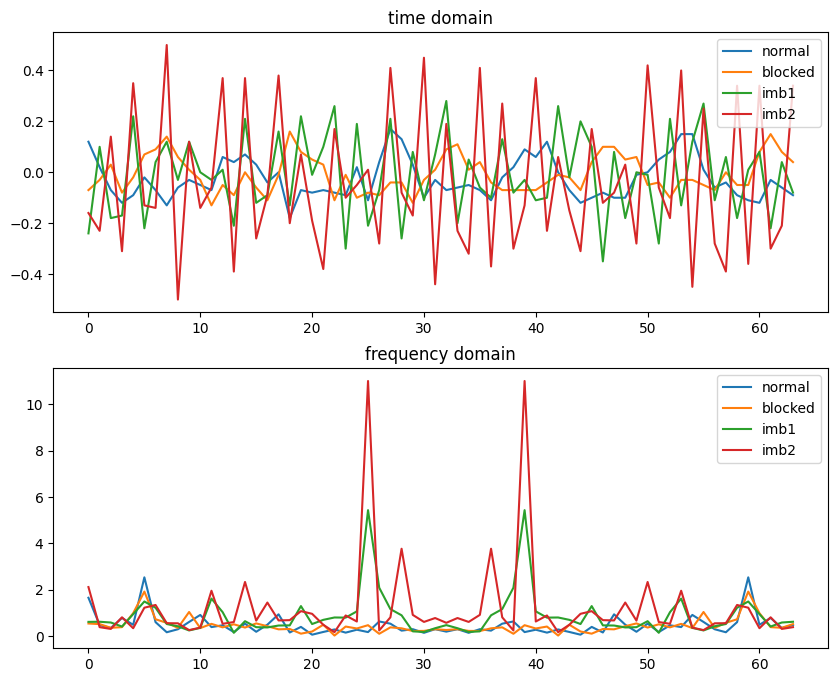

In [69]:
#cek data time domain
plt.figure(figsize=(10, 8))
plt.subplot(211)
plt.plot(normal_sep[55], label="normal")
plt.plot(blocked_sep[55], label="blocked")
plt.plot(imb1_sep[55], label="imb1")
plt.plot(imb2_sep[55], label="imb2")
plt.title("time domain")
plt.legend()

#cek data frequency domain
plt.subplot(212)
plt.plot(normal_fourier_mag[55], label="normal")
plt.plot(blocked_fourier_mag[55], label="blocked")
plt.plot(imb1_fourier_mag[55], label="imb1")
plt.plot(imb2_fourier_mag[55], label="imb2")
plt.title("frequency domain")
plt.legend()
plt.show()

Supaya lebih detail lagi, kita coba plot semua dataset pada domain frequency:

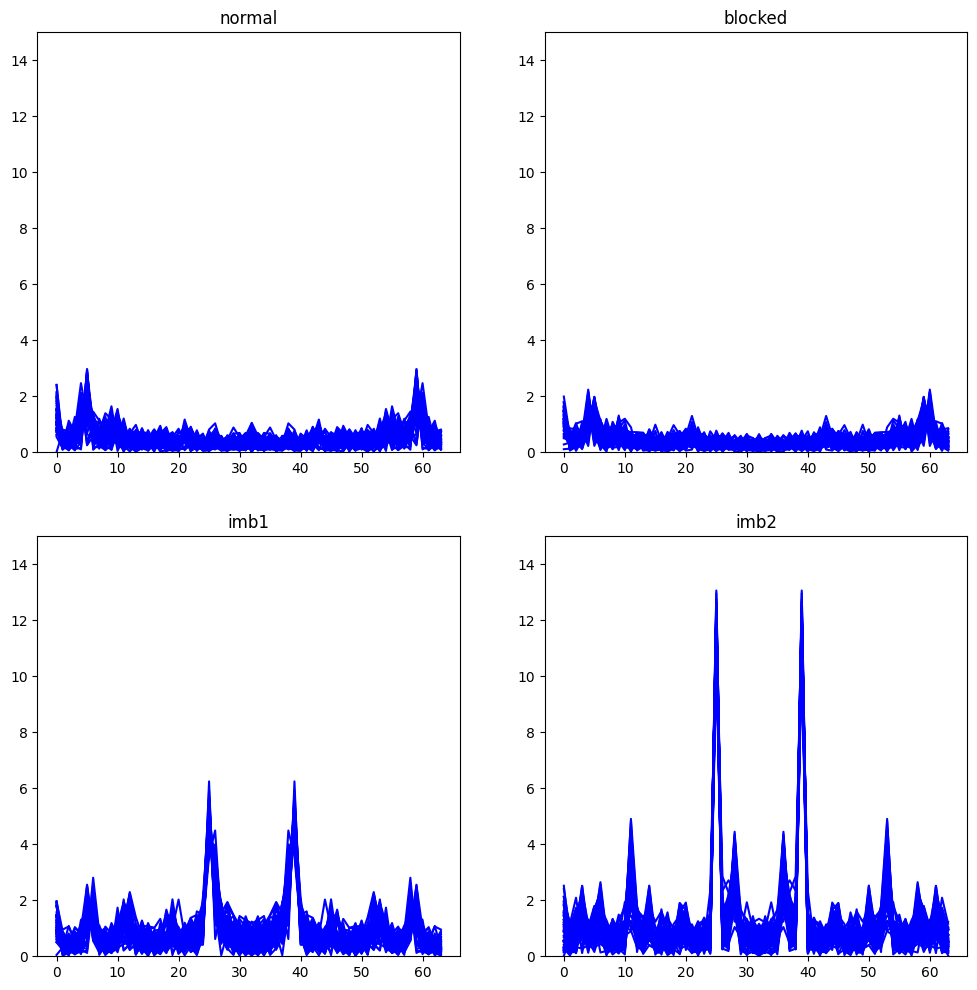

In [73]:
#Check fourier_mag pattern for each class
n = len(normal_fourier_mag[0])

plt.figure(figsize=(12,12))

for i in range(n):
    plt.subplot(221)
    plt.plot(normal_fourier_mag[i], "b")
    plt.ylim(0,15)
plt.title("normal")

for i in range(n):
    plt.subplot(222)
    plt.plot(blocked_fourier_mag[i], "b")
    plt.ylim(0,15)
plt.title("blocked")

for i in range(n):
    plt.subplot(223)
    plt.plot(imb1_fourier_mag[i], "b")
    plt.ylim(0,15)
plt.title("imb1")

for i in range(n):
    plt.subplot(224)
    plt.plot(imb2_fourier_mag[i], "b")
    plt.ylim(0,15)
plt.title("imb2")

plt.show()

Dapat diamati bahwa pola unik pada frequency domain lebih mudah diamati dibandingkan time domain. Secara sekilas, perbedaan tiap kelas dapat diamati dengan mudah pada puncak amplitude yang berbentuk "tanduk rumah padang".